In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib as mpl
from cmcrameri import cm as cmc
import pandas as pd
import xarray as xr
import itertools


import pdb
import sys
sys.path.insert(0, '../lib')
sys.path.insert(0, '../src')
from scipy.stats import norm, beta, bernoulli


import ml_estimation as ml
import ml_estimation2 as ml2
import model1_plots as mp
import model1_explore as me
import model1_sim as sim1
import Utilities as util

In [2]:
## simulation results
method = 'main_beta'
T = 50
N = 100
X = xr.open_dataset(f'..\mod\model2\sim\simulation2_{method}_T{T}_N{N}_image_20201210-15h1457.nc')


In [3]:
## original images
loc_clean_data = '../data/clean_data/'
import pickle
from datetime import datetime 
with open(loc_clean_data + 'clean_dates.txt', 'rb') as f:
    dates = pickle.load(f)

# print(dates)
date = dates.date

start_date = datetime.strptime('10-12-2020', '%d-%m-%Y')
end_date = datetime.strptime('11-12-2020', '%d-%m-%Y')
idx = (start_date < date)  & (date < end_date) 

dates = dates[idx]

file = dates.file_name.loc[0]
images = xr.open_dataset(file)
images

# Only keep points which are in the right area and do contain a wind speed
dss = []
for file in dates.file_name:
    images = xr.open_dataset(file)
    dss.append(images)

images = xr.concat(dss, 't')

invalid =np.sum(images.ct == 0, axis = (1,2))
images = images.where(invalid < 10000, drop = True)

images = images.rename(dict(x = 'i', y = 'j'))
images = images.rename(dict(cth = 'h', cod = 'd'))

images['i'] = range(len(images.i))
images['j'] = range(len(images.j))
images['d'] = np.log(images.d)
images['z'] = (['t', 'i', 'j'], np.select([images.ct == 1, (images.ct > 1) & (~np.isnan(images.d)) & (~np.isnan(images.h))], [1, 0], np.nan))
# images['z_cloud'] = images.z.where(~np.isnan(images.d) & ~np.isnan(images.h))

images['d'] = images.d.where(images.z == 0)
images['h'] = images.h.where(images.z == 0)

In [13]:
### 20201210-15h1457
images.t[23]

<xarray.DataArray 't' ()>
array('2020-12-10T15:14:57.895445888', dtype='datetime64[ns]')
Coordinates:
    t        datetime64[ns] 2020-12-10T15:14:57.895445888

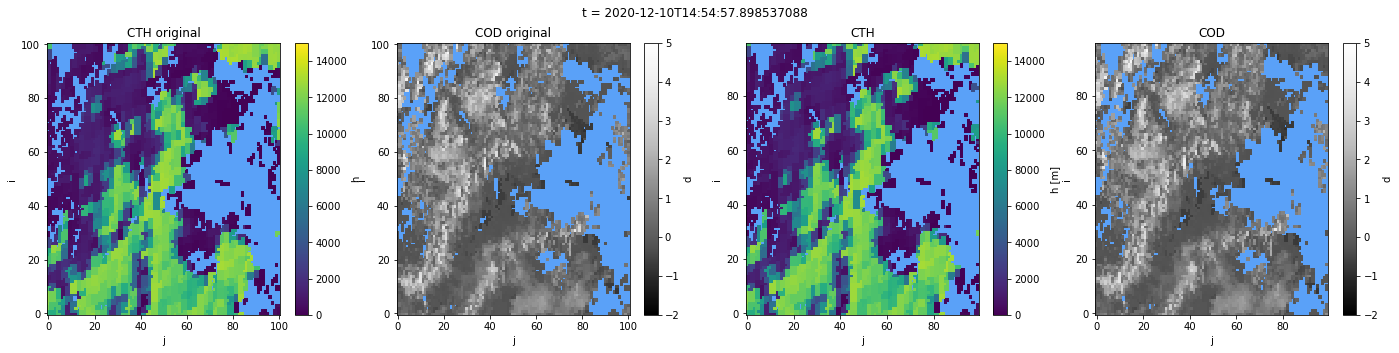

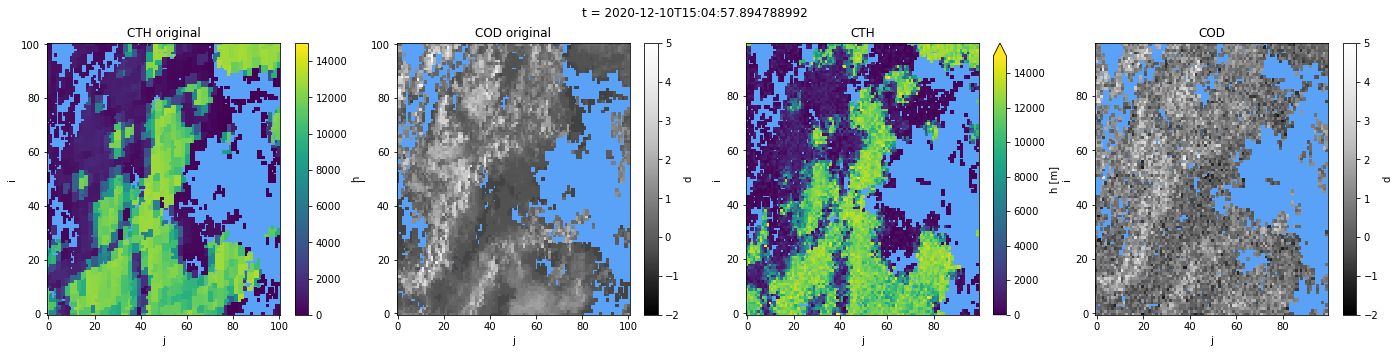

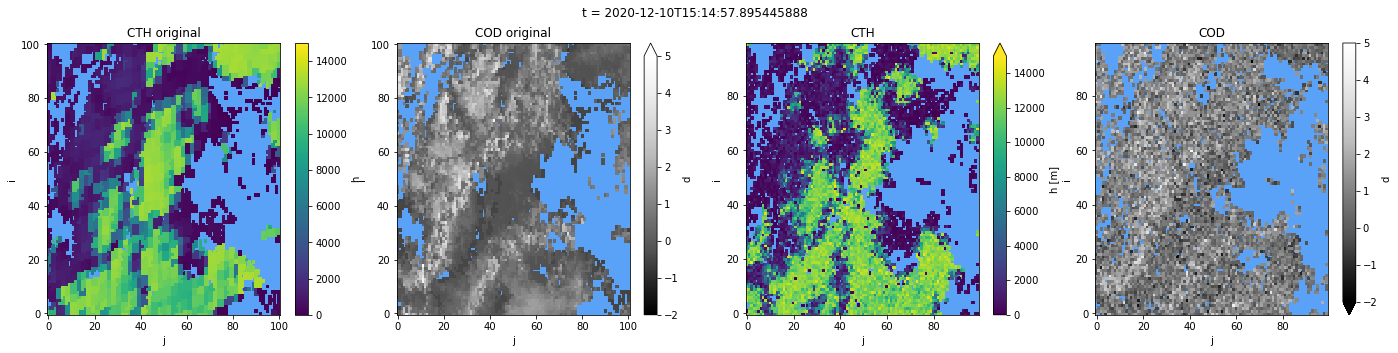

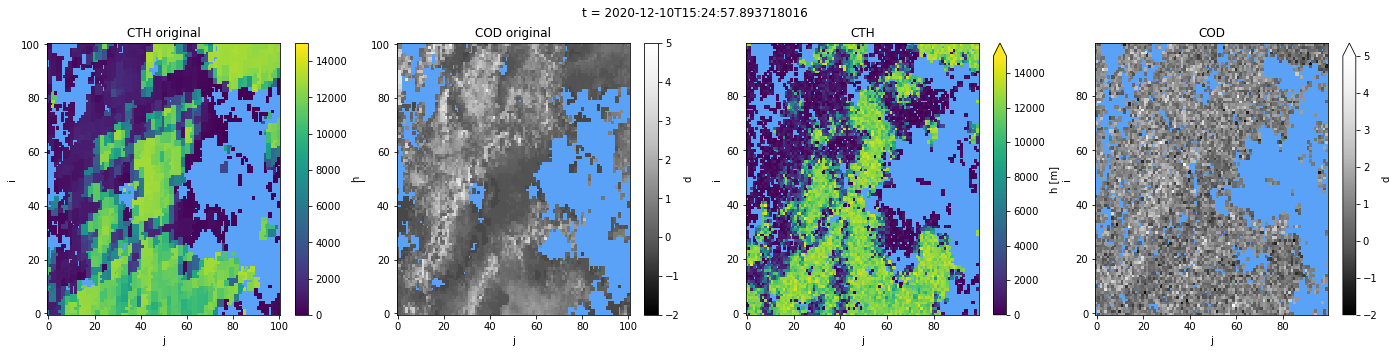

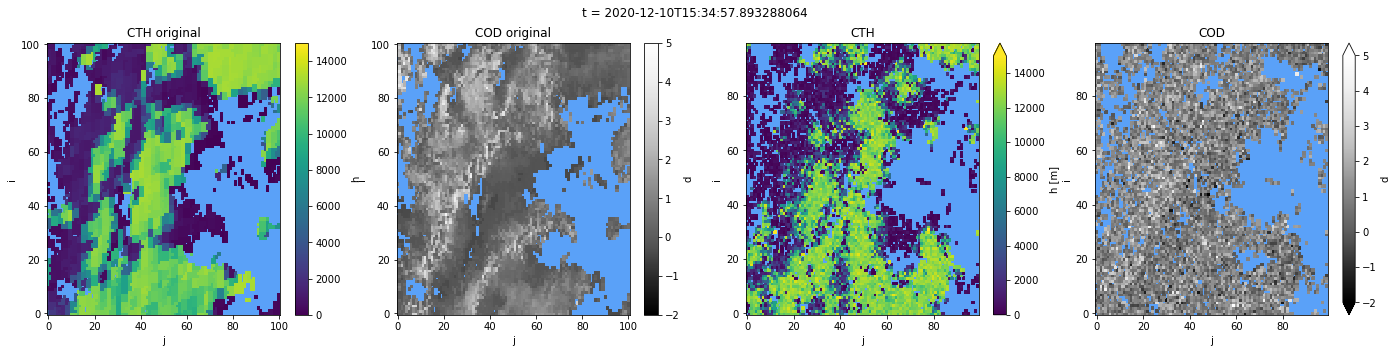

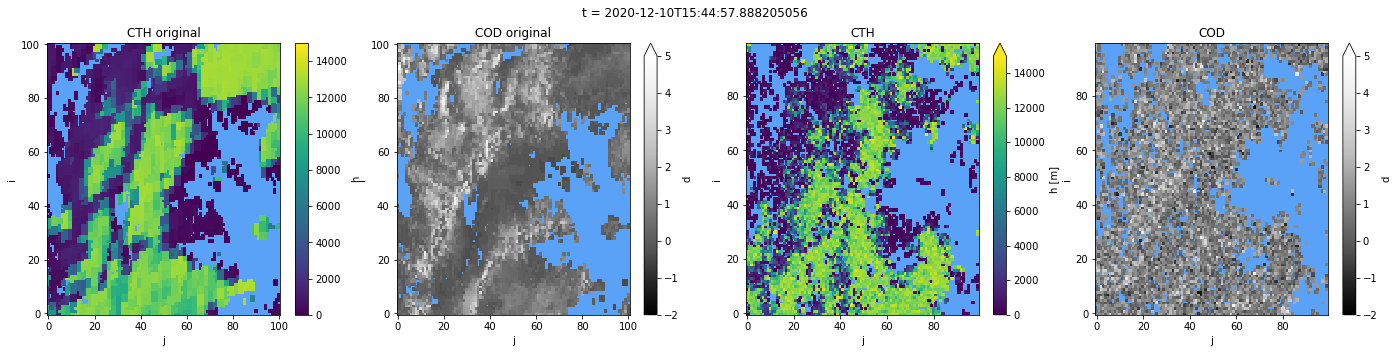

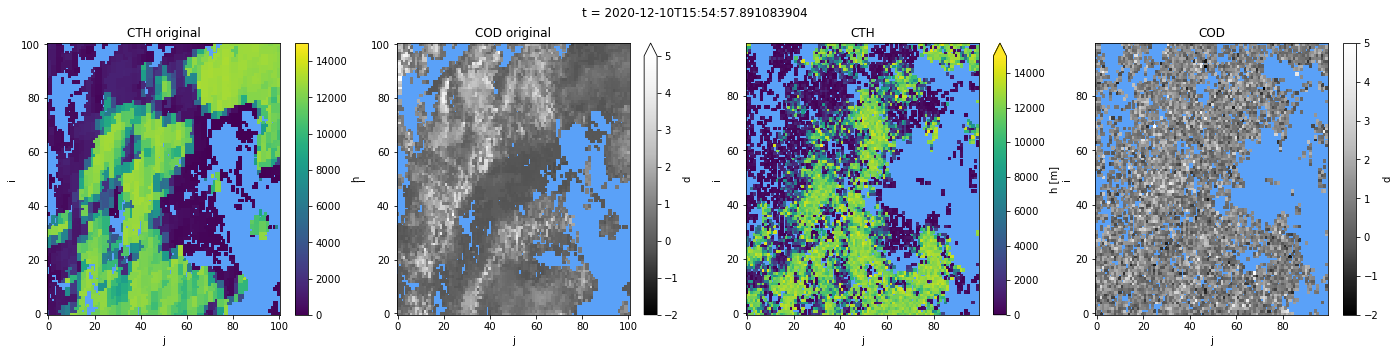

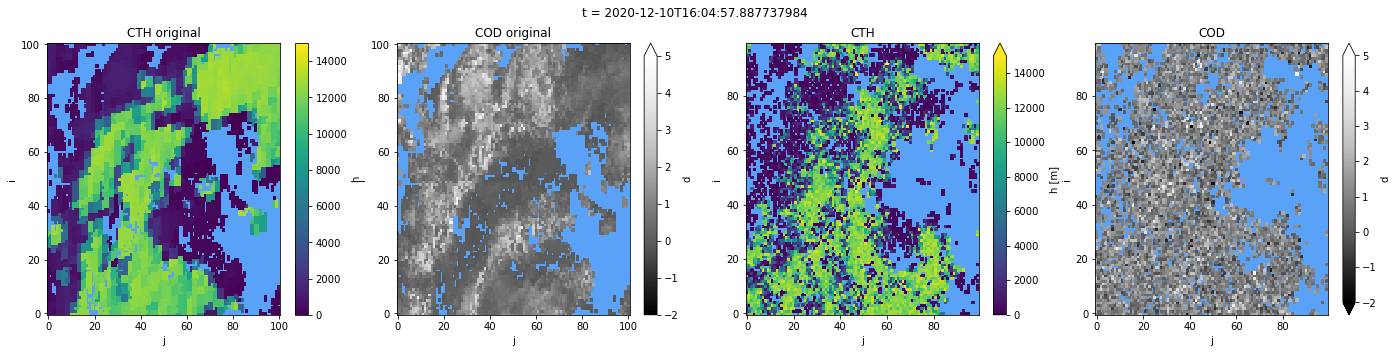

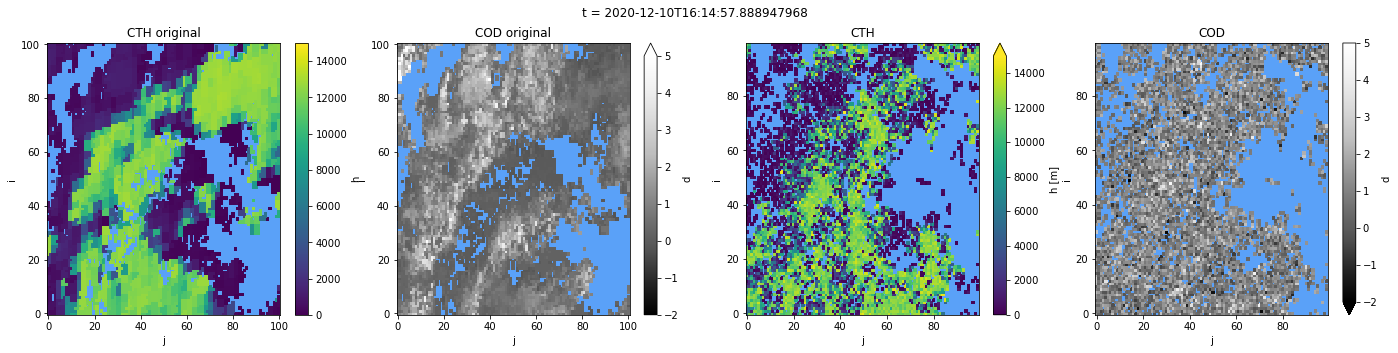

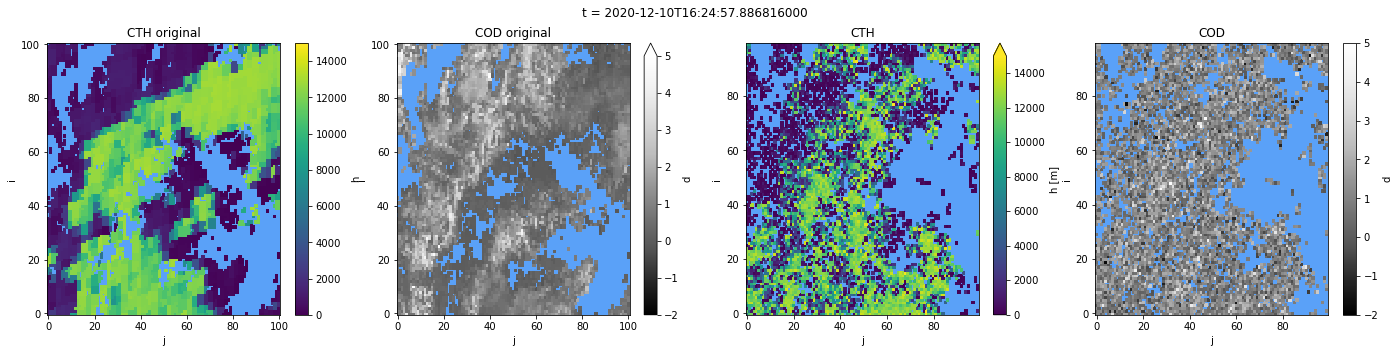

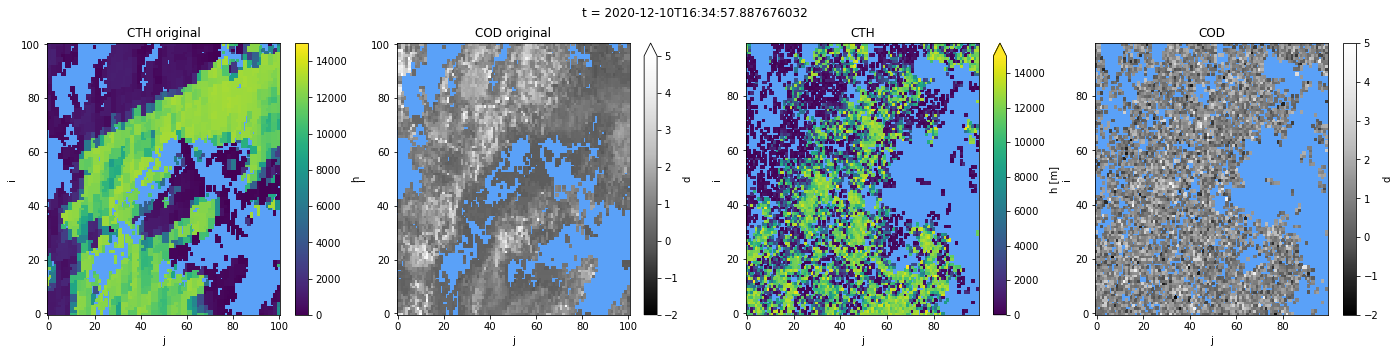

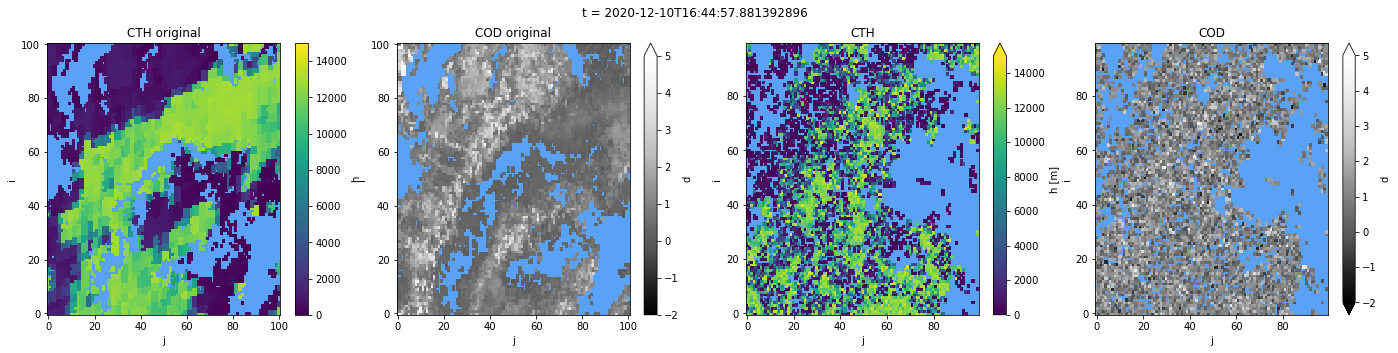

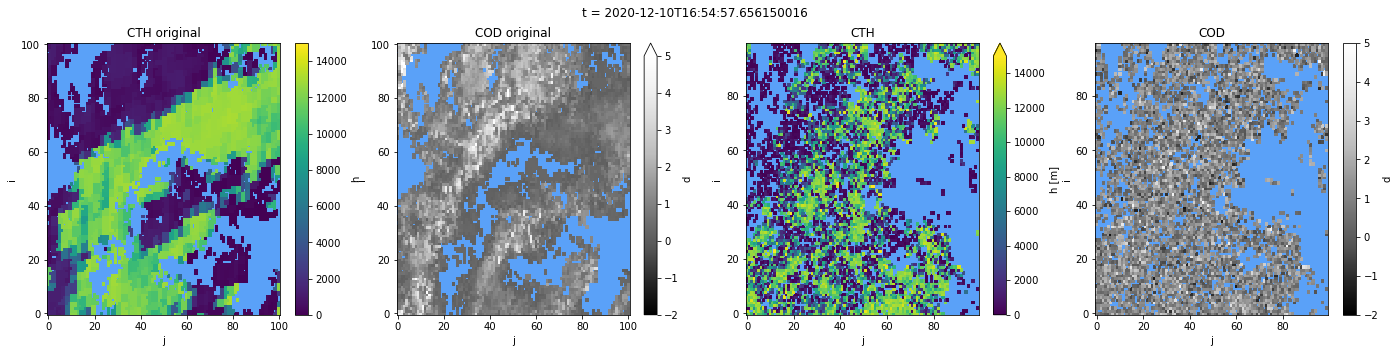

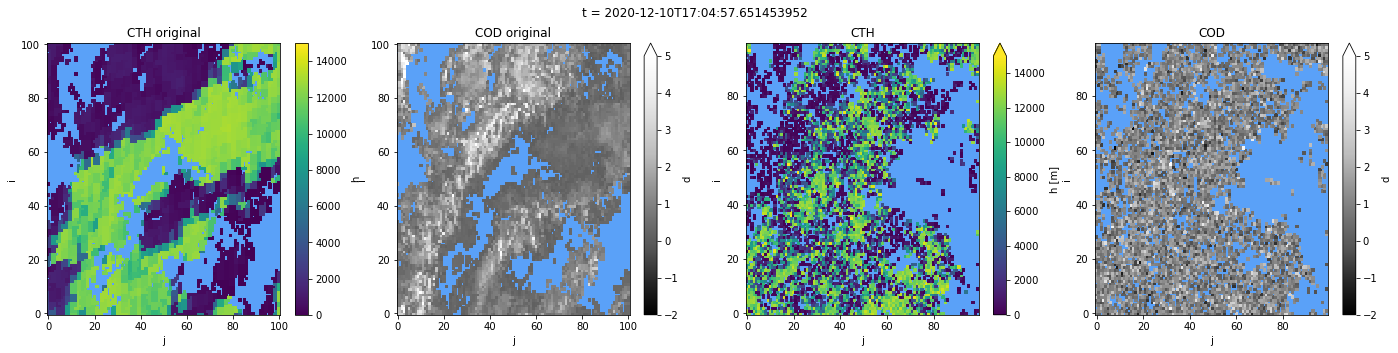

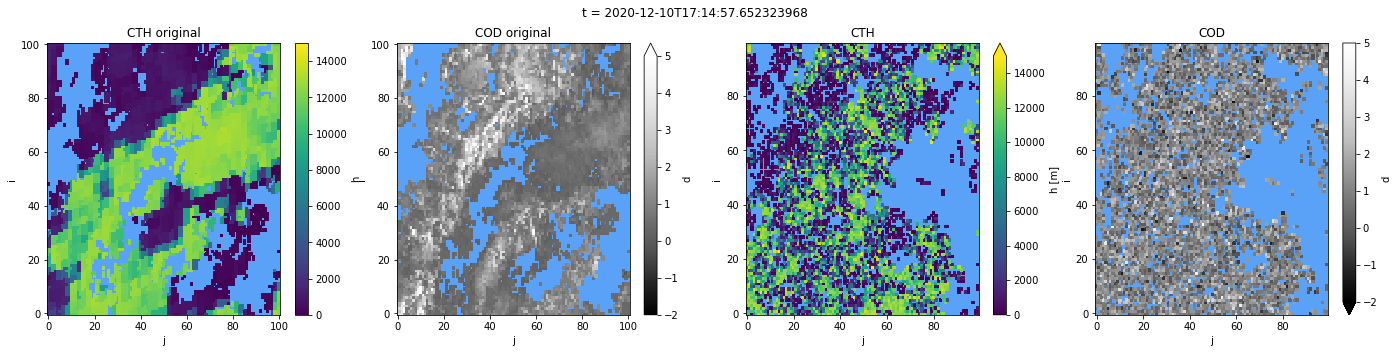

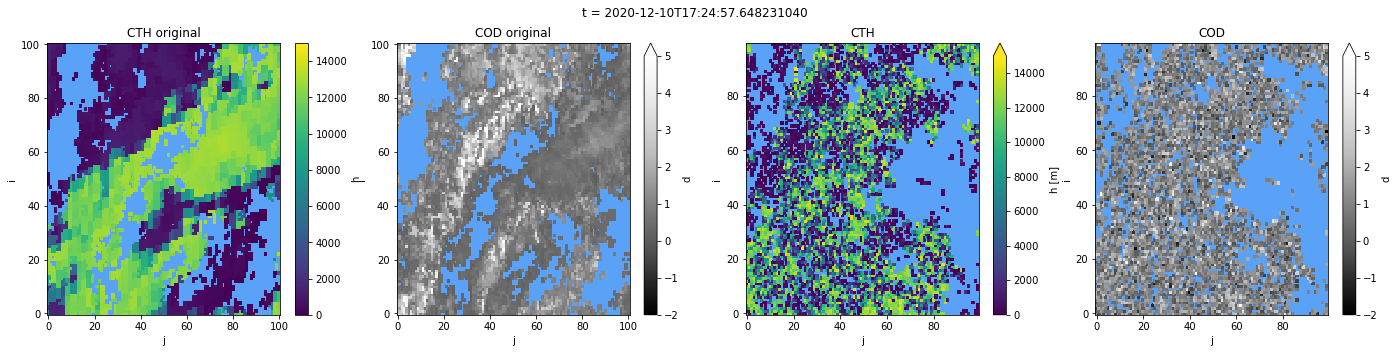

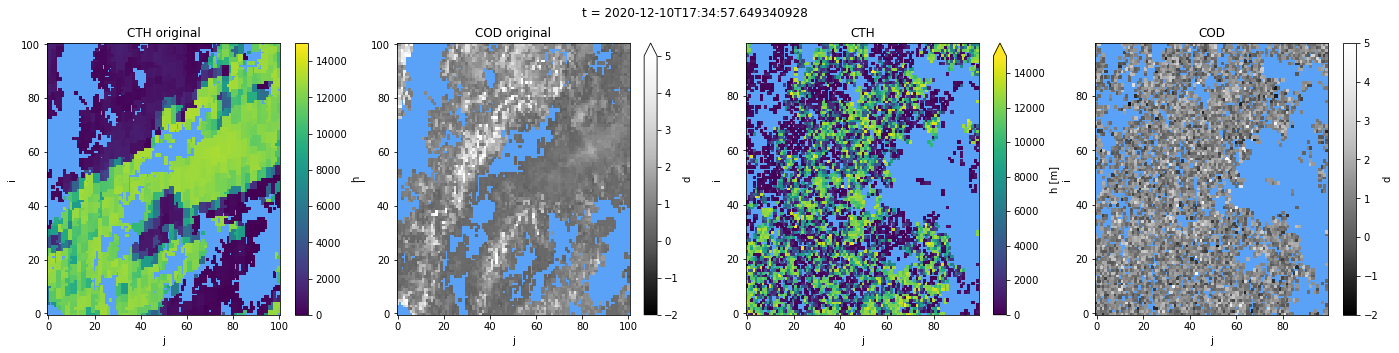

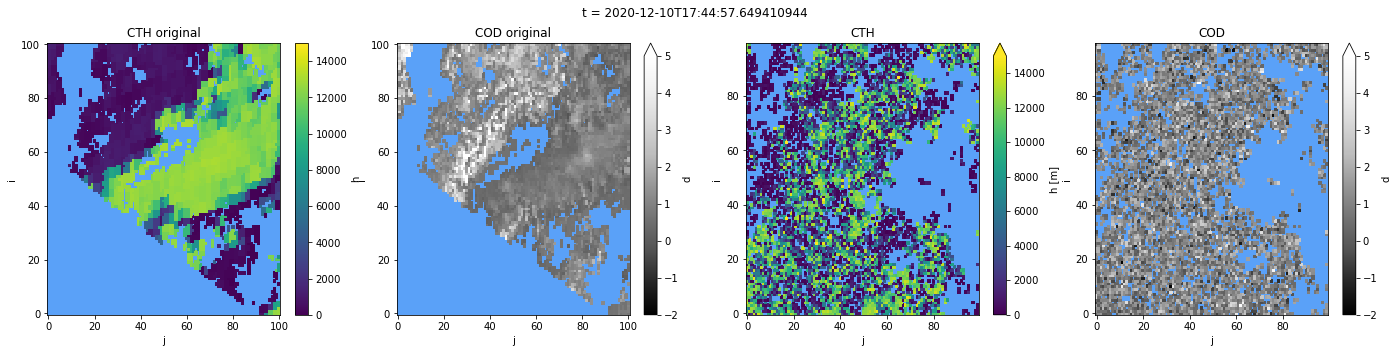

IndexError: index 39 is out of bounds for axis 0 with size 39

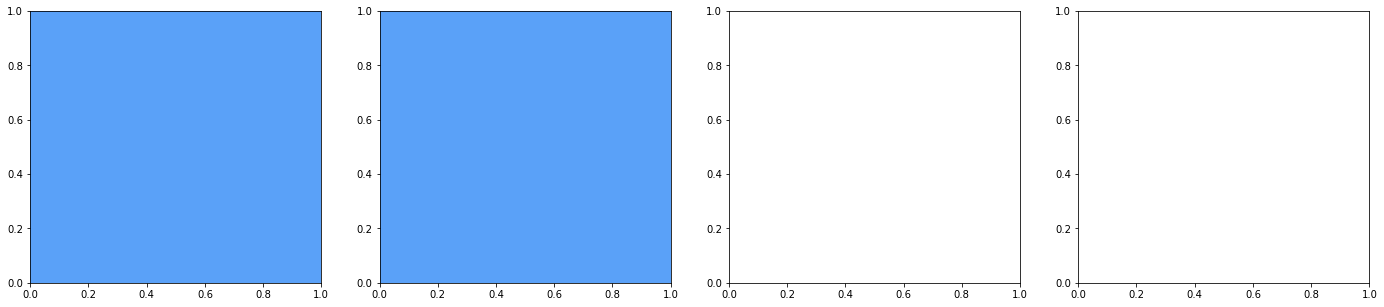

In [19]:
# xr.plot.imshow(ds.RGB_colorbar)
# plt.show()
# X = Xo

hlim = [0, 15e3]
dlim = [-2, 5]

for t in X.t.data:
    fig, ax = plt.subplots(1,4, figsize = (24, 5))
#     xr.plot.imshow(X.loc[dict(t = t)].RGB,
#                    ax = ax[0]
#                   )
    ax[0].patch.set_facecolor('#5AA1F8')
    ax[1].patch.set_facecolor('#5AA1F8')
    
    images.sel(t = images.t[t + 21], i = slice(N), j = slice(N)).h.plot(ax = ax[0], vmin = hlim[0], vmax = hlim[1])
    images.sel(t = images.t[t + 21], i = slice(N), j = slice(N)).d.plot(ax = ax[1], cmap = cm.Greys_r, vmin = dlim[0], vmax = dlim[1]) 
    
    ax[0].set_title('CTH original')
    ax[1].set_title('COD original')
    
    
    ax[2].patch.set_facecolor('#5AA1F8')
    ax[3].patch.set_facecolor('#5AA1F8')
    
    X.sel(t = t).h.plot(ax = ax[2], vmin = hlim[0], vmax = hlim[1])
    X.sel(t = t).d.plot(ax = ax[3], cmap = cm.Greys_r, vmin = dlim[0], vmax = dlim[1]) 
    
    ax[2].set_title('CTH')
    ax[3].set_title('COD')
    
    plt.suptitle(f't = {images.t[t + 21].data}')
    plt.savefig(f'../fig/model2/sim_model2_{method}_T{T}_N{N}_t{t}.png')
    plt.show()
    

# auto correlation function in one direction

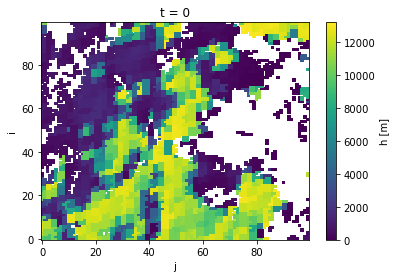

In [20]:
x = X.sel(t=0).h
x.plot()

In [21]:
lag1 = x.roll(j = 1, roll_coords = False)
lag1

<xarray.DataArray 'h' (i: 100, j: 100)>
array([[  579.2766 , 10050.969  ,  9366.702  , ...,         nan,
                nan,   579.2766 ],
       [  579.2766 , 10050.969  ,  9366.702  , ...,         nan,
                nan,   579.2766 ],
       [  426.67477, 11882.19   , 10777.658  , ...,         nan,
                nan,         nan],
       ...,
       [12806.652  ,  3175.0342 ,  3175.0342 , ..., 12739.508  ,
        12739.508  , 12549.061  ],
       [12549.061  ,  3175.0342 ,  3175.0342 , ..., 12739.508  ,
        12739.508  , 12549.061  ],
       [12549.061  , 10687.013  , 10687.013  , ..., 12739.508  ,
        12739.508  , 12549.061  ]], dtype=float32)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 ... 90 91 92 93 94 95 96 97 98 99
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 ... 90 91 92 93 94 95 96 97 98 99
    t        int64 0
Attributes:
    units:    m

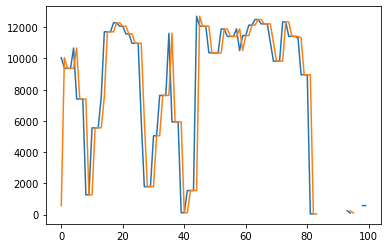

In [22]:
import statsmodels.api as sm

def ACF(x, n = 40):
    acf = [xr.cov(x, x.roll(j = k, roll_coords = False)).data for k in range(n)]
    return acf

# plt.plot(acf)
plt.plot(x.sel(i = 1))
plt.plot(lag1.sel(i = 1))
plt.show()

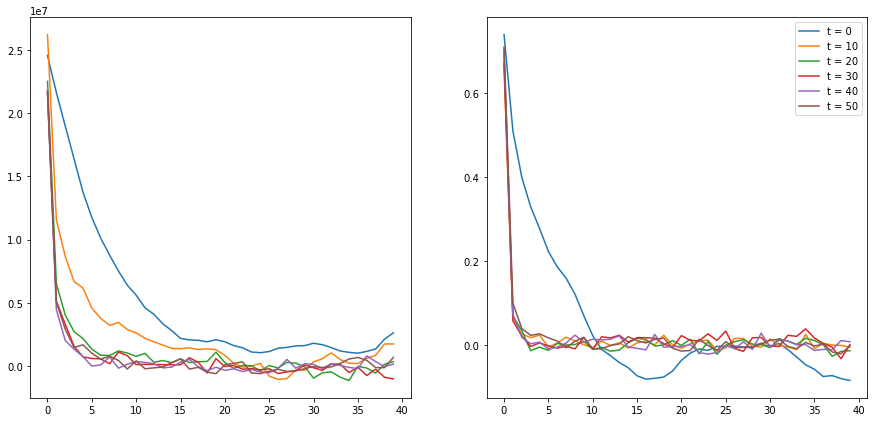

In [23]:
T = [0, 10, 20, 30, 40, 50]
fig, ax = plt.subplots(1,2, figsize = (15,7))


for t in T:
#     plt.plot(ACF(x))
    ax[0].plot(ACF(X.sel(t = t).h), label = f't = {t}')
    ax[1].plot(ACF(X.sel(t = t).d), label = f't = {t}')
plt.legend()

# lag1

In [24]:
from xarray import DataArray
da_a = DataArray(
    np.array([[1, 2, 3], [0.1, 0.2, 0.3], [3.2, 0.6, 1.8]]),
    dims=("space", "time"),
    coords=[
        ("space", ["IA", "IL", "IN"]),
        ("time", pd.date_range("2000-01-01", freq="1D", periods=3)),
    ],
)
da_a
da_b = DataArray(
    np.array([[0.2, 0.4, 0.6], [15, 10, 5], [3.2, 0.6, 1.8]]),
    dims=("space", "time"),
    coords=[
        ("space", ["IA", "IL", "IN"]),
        ("time", pd.date_range("2000-01-01", freq="1D", periods=3)),
    ],
)
da_b
xr.cov(da_a, da_b)
xr.cov(da_a, da_b, dim="time")

<xarray.DataArray (space: 3)>
array([ 0.2       , -0.5       ,  1.69333333])
Coordinates:
  * space    (space) <U2 'IA' 'IL' 'IN'

In [25]:
da_a.var(), da_b.var()

(<xarray.DataArray ()>
 array(1.27135802),
 <xarray.DataArray ()>
 array(23.76987654))

(512, 512)


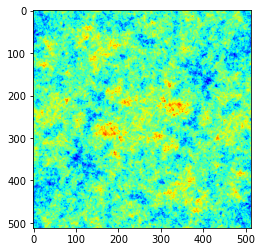

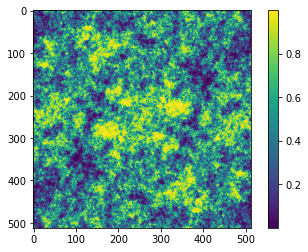

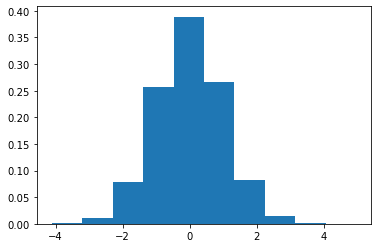

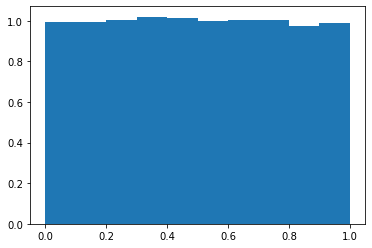

In [26]:
from FyeldGenerator import generate_field
plt.figure()

# Helper that generates power-law power spectrum
def Pkgen(n):
    def Pk(k):
        return np.power(k, -n)

    return Pk

# Draw samples from a normal distribution
def distrib(shape):
    a = np.random.normal(loc=0, scale=1, size=shape)
    b = np.random.normal(loc=0, scale=1, size=shape)
    return a #+ 1j * b


shape = (512, 512)
field = generate_field(distrib, Pkgen(2), shape)

field = field/field.std()


print(field.shape)
plt.imshow(field[:,:], cmap='jet')
plt.show()

plt.imshow(norm.cdf(field))
plt.colorbar()
plt.show()

plt.hist(field.flatten(), density = True)
plt.show()
plt.hist(norm.cdf(field).flatten(), density = True)
plt.show()
# field.std()

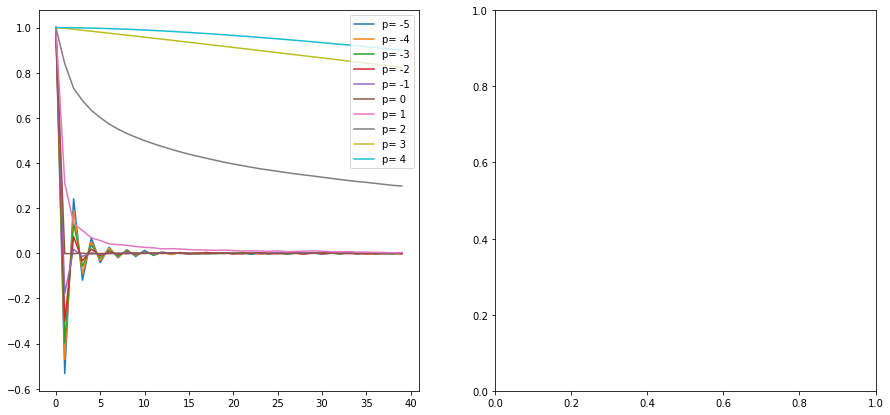

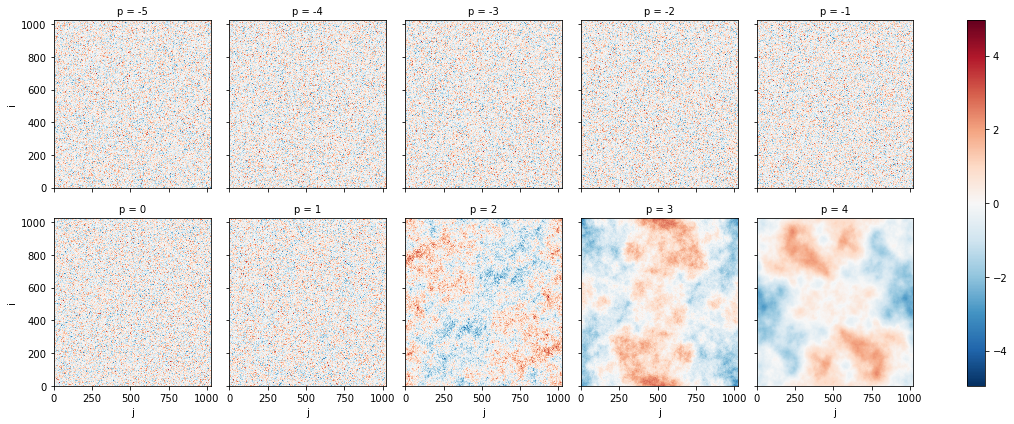

In [58]:
field
p = np.arange(-5, 5)

ds = []
shape = (512* 2, 512 * 2)

for p in p:

    field = generate_field(distrib, Pkgen(p), shape)
    field = field/field.std()
    
    da = xr.DataArray(
        data=field,
        dims=["i", "j"],
        coords=dict(
            p=p,
        ),
    )
    ds.append(da)
ds = xr.concat(ds, dim = 'p')
fig, ax = plt.subplots(1,2, figsize = (15,7))


for p in ds.p:
#     plt.plot(ACF(x))
    ax[0].plot(ACF(ds.sel(p = p), n = 40), label = f'p= {p.data}')
#     ax[1].plot(ACF(X.sel(t = t).d), label = f't = {t}')
ax[0].legend()

# lag1
ds.plot(col = 'p', col_wrap = 5)